In [205]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv
/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv


***Importing Libraries***

In [206]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor,AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.ensemble import VotingRegressor
import xgboost as xgb


***Importing Dataset***

In [207]:
train_data=pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/train.csv')
test_data=pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/test.csv')
sample=pd.read_csv('/kaggle/input/taxi-fare-guru-total-amount-prediction-challenge/sample.csv.csv')

***Exploring Dataset***

In [208]:
train_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,2.5,7.165589,0.0,1.0,20.64,2.5,0.0
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,3.5,6.067401,0.0,1.0,25.55,2.5,0.0
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,0.0,4.111547,0.0,1.0,17.64,2.5,0.0
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,2.5,6.411079,0.0,1.0,12.80,2.5,0.0
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,1.0,4.769377,0.0,1.0,18.00,2.5,0.0


In [209]:
print(train_data.shape)
print(test_data.shape)

(175000, 17)
(50000, 16)


In [210]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 17 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   tpep_pickup_datetime   175000 non-null  object 
 2   tpep_dropoff_datetime  175000 non-null  object 
 3   passenger_count        168923 non-null  float64
 4   trip_distance          175000 non-null  float64
 5   RatecodeID             168923 non-null  float64
 6   store_and_fwd_flag     168923 non-null  object 
 7   PULocationID           175000 non-null  int64  
 8   DOLocationID           175000 non-null  int64  
 9   payment_type           175000 non-null  object 
 10  extra                  175000 non-null  float64
 11  tip_amount             175000 non-null  float64
 12  tolls_amount           175000 non-null  float64
 13  improvement_surcharge  175000 non-null  float64
 14  total_amount           175000 non-nu

In [211]:
def preprocess_taxi_data(data):
    data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
    data['tpep_dropoff_datetime'] = pd.to_datetime(data['tpep_dropoff_datetime'])

    data['pickup_day'] = data['tpep_pickup_datetime'].dt.day_name()
    data['dropoff_day'] = data['tpep_dropoff_datetime'].dt.day_name()
    data['pickup_day_no'] = data['tpep_pickup_datetime'].dt.weekday
    data['dropoff_day_no'] = data['tpep_dropoff_datetime'].dt.weekday
    data['pickup_hour'] = data['tpep_pickup_datetime'].dt.hour
    data['dropoff_hour'] = data['tpep_dropoff_datetime'].dt.hour
    data['pickup_month'] = data['tpep_pickup_datetime'].dt.month
    data['dropoff_month'] = data['tpep_dropoff_datetime'].dt.month
    data['total_pickup_hours'] = data['pickup_day_no'] * 24 + data['pickup_hour']
    data['total_dropoff_hours'] = data['dropoff_day_no'] * 24 + data['dropoff_hour']
    data['trip_duration_hours'] = abs(data['total_dropoff_hours'] - data['total_pickup_hours'])

    def time_of_day(x):
        if x in range(4, 12):
            return 'Morning'
        elif x in range(12, 16):
            return 'Afternoon'
        elif x in range(16, 20):
            return 'Evening'
        else:
            return 'Night'

    data['pickup_timeofday'] = data['pickup_hour'].apply(time_of_day)
    data['dropoff_timeofday'] = data['dropoff_hour'].apply(time_of_day)
    return data



In [212]:
preprocessed_train_data = preprocess_taxi_data(train_data)
preprocessed_test_data = preprocess_taxi_data(test_data)

In [213]:
preprocessed_train_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,total_pickup_hours,total_dropoff_hours,trip_duration_hours,pickup_timeofday,dropoff_timeofday
0,1,2023-06-28 17:20:21,2023-06-28 16:34:45,1.0,2.14,1.0,N,120,9,Credit Card,...,2,17,16,6,6,65,64,1,Evening,Evening
1,0,2023-06-29 23:05:01,2023-06-29 22:01:35,1.0,2.70,1.0,N,15,215,Credit Card,...,3,23,22,6,6,95,94,1,Night,Night
2,1,2023-06-30 10:19:31,2023-06-30 11:13:10,1.0,1.15,1.0,N,167,223,Credit Card,...,4,10,11,6,6,106,107,1,Morning,Morning
3,0,2023-06-29 13:23:09,2023-06-29 14:20:01,1.0,0.40,1.0,N,128,239,Credit Card,...,3,13,14,6,6,85,86,1,Afternoon,Afternoon
4,1,2023-06-29 22:03:32,2023-06-29 22:22:22,3.0,1.10,1.0,N,203,52,Credit Card,...,3,22,22,6,6,94,94,0,Night,Night


In [214]:
preprocessed_test_data.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,total_pickup_hours,total_dropoff_hours,trip_duration_hours,pickup_timeofday,dropoff_timeofday
0,1,2023-06-29 00:21:20,2023-06-29 00:25:20,1.0,4.95,1.0,N,20,3,Credit Card,...,3,0,0,6,6,72,72,0,Night,Night
1,1,2023-06-30 17:44:43,2023-06-30 17:53:13,1.0,2.10,1.0,N,9,81,Credit Card,...,4,17,17,6,6,113,113,0,Evening,Evening
2,1,2023-06-29 18:17:04,2023-06-29 19:23:48,1.0,0.95,1.0,N,92,90,Cash,...,3,18,19,6,6,90,91,1,Evening,Evening
3,0,2023-06-30 21:33:53,2023-06-30 21:46:20,1.0,0.80,1.0,N,19,102,Credit Card,...,4,21,21,6,6,117,117,0,Night,Night
4,1,2023-06-29 14:53:54,2023-06-29 15:22:17,1.0,4.01,1.0,N,131,229,Cash,...,3,14,15,6,6,86,87,1,Afternoon,Afternoon


In [215]:
preprocessed_train_data.drop('tpep_pickup_datetime',axis=1,inplace=True)
preprocessed_train_data.drop('tpep_dropoff_datetime',axis=1,inplace=True)



preprocessed_test_data.drop('tpep_pickup_datetime',axis=1,inplace=True)
preprocessed_test_data.drop('tpep_dropoff_datetime',axis=1,inplace=True)

In [216]:
preprocessed_train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
VendorID,175000.0,0.728377,0.445606,0.000000,0.000000,1.000000,1.000000,2.000000
passenger_count,168923.0,1.357678,0.891283,0.000000,1.000000,1.000000,1.000000,9.000000
trip_distance,175000.0,5.145930,394.971052,0.000000,1.080000,1.840000,3.610000,135182.060000
RatecodeID,168923.0,1.518307,6.514678,1.000000,1.000000,1.000000,1.000000,99.000000
PULocationID,175000.0,132.710349,76.148799,1.000000,67.000000,133.000000,199.000000,264.000000
DOLocationID,175000.0,132.701429,76.192493,1.000000,67.000000,133.000000,199.000000,264.000000
extra,175000.0,1.932143,1.948497,-7.500000,0.000000,1.000000,2.500000,11.750000
tip_amount,175000.0,6.127497,4.610834,0.000079,3.473321,5.286217,7.502746,484.876151
tolls_amount,175000.0,0.646816,2.328274,-29.300000,0.000000,0.000000,0.000000,80.000000
improvement_surcharge,175000.0,0.979689,0.198775,-1.000000,1.000000,1.000000,1.000000,1.000000


**Statistical Summary:**

Trip Distance: Has a very high standard deviation and a maximum value that seems like an outlier (135,182.06). This suggests the presence of extreme values.

RatecodeID: Also has a high maximum value, indicating potential outliers or data entry errors.

Negative Values: There are negative values in extra, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, and Airport_fee, which might need investigation as they could be data entry errors.



In [217]:
unique_values_per_vendor = preprocessed_train_data.groupby('VendorID').nunique()

unique_values_per_vendor.transpose()

VendorID,0,1,2
passenger_count,7,9,0
trip_distance,341,2860,62
RatecodeID,6,5,0
store_and_fwd_flag,2,2,0
PULocationID,264,264,52
DOLocationID,264,264,58
payment_type,5,5,1
extra,18,20,1
tip_amount,47597,127340,63
tolls_amount,82,189,1


# **MISSING VALUES**

<Axes: >

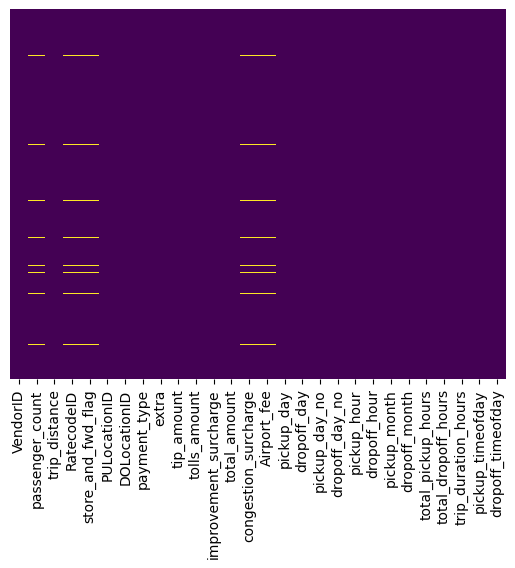

In [218]:
sns.heatmap(preprocessed_train_data.isnull(),yticklabels=False,cmap='viridis',cbar=False)

In [219]:
print(preprocessed_train_data.isnull().sum())

VendorID                    0
passenger_count          6077
trip_distance               0
RatecodeID               6077
store_and_fwd_flag       6077
PULocationID                0
DOLocationID                0
payment_type                0
extra                       0
tip_amount                  0
tolls_amount                0
improvement_surcharge       0
total_amount                0
congestion_surcharge     6077
Airport_fee              6077
pickup_day                  0
dropoff_day                 0
pickup_day_no               0
dropoff_day_no              0
pickup_hour                 0
dropoff_hour                0
pickup_month                0
dropoff_month               0
total_pickup_hours          0
total_dropoff_hours         0
trip_duration_hours         0
pickup_timeofday            0
dropoff_timeofday           0
dtype: int64


In [220]:
features_with_na=[features for features in preprocessed_train_data.columns if preprocessed_train_data[features].isnull().sum()>0]

features_with_na

['passenger_count',
 'RatecodeID',
 'store_and_fwd_flag',
 'congestion_surcharge',
 'Airport_fee']

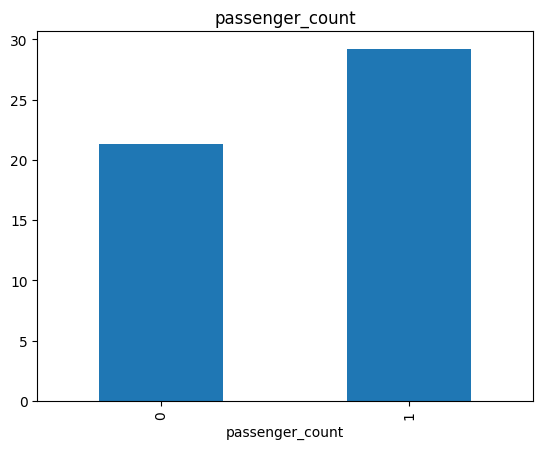

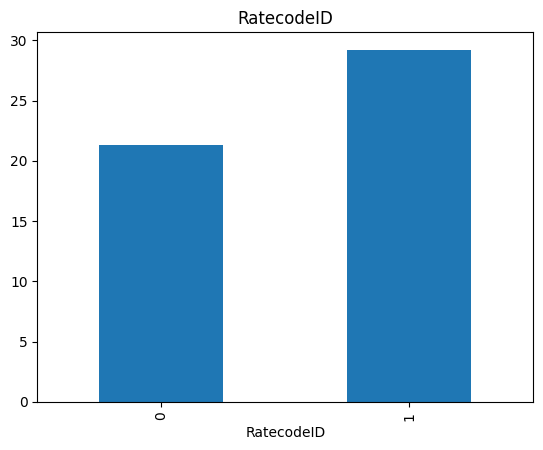

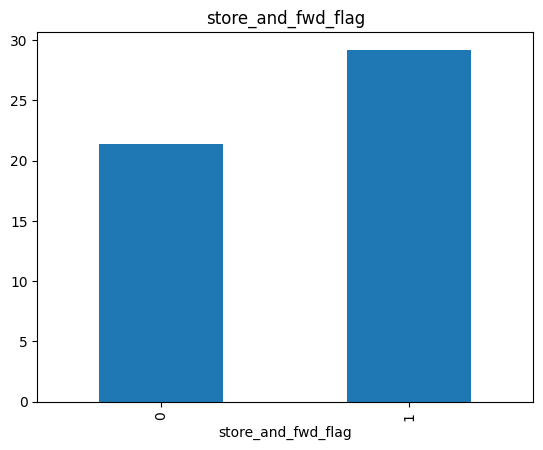

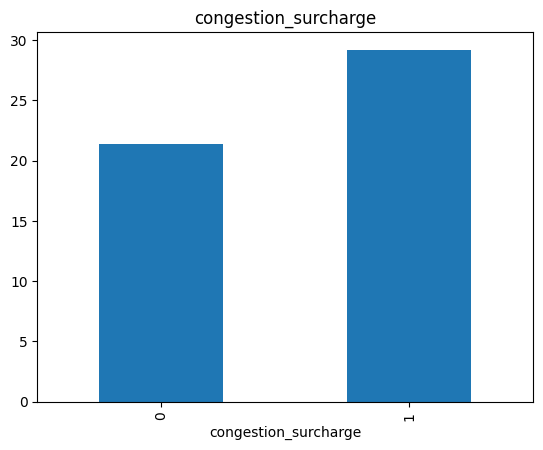

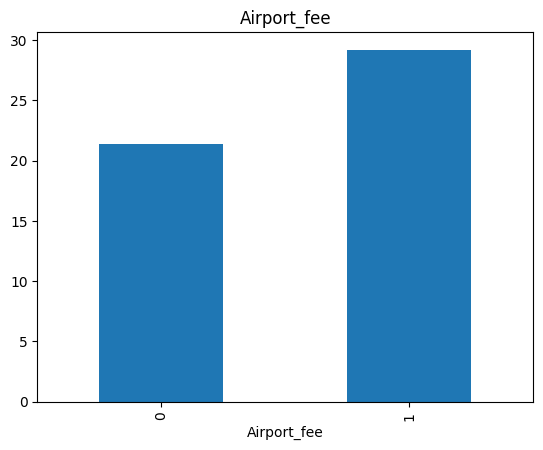

In [221]:
df=preprocessed_train_data.copy()

for feature in features_with_na:
    df[feature] = np.where(df[feature].isnull(), 1, 0)
    df.groupby(feature)['total_amount'].median().plot.bar()
    plt.title(feature)
    plt.show()

**Insight** : The absence of data in that feature correlates with higher transaction amounts
so its is important to compute the missing values instead od dropping it.

# **EDA**

In [222]:
 preprocessed_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175000 entries, 0 to 174999
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               175000 non-null  int64  
 1   passenger_count        168923 non-null  float64
 2   trip_distance          175000 non-null  float64
 3   RatecodeID             168923 non-null  float64
 4   store_and_fwd_flag     168923 non-null  object 
 5   PULocationID           175000 non-null  int64  
 6   DOLocationID           175000 non-null  int64  
 7   payment_type           175000 non-null  object 
 8   extra                  175000 non-null  float64
 9   tip_amount             175000 non-null  float64
 10  tolls_amount           175000 non-null  float64
 11  improvement_surcharge  175000 non-null  float64
 12  total_amount           175000 non-null  float64
 13  congestion_surcharge   168923 non-null  float64
 14  Airport_fee            168923 non-nu

<Axes: xlabel='passenger_count', ylabel='count'>

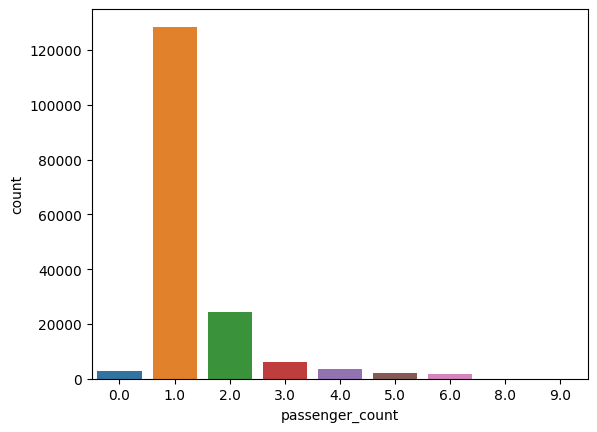

In [223]:
sns.countplot(x='passenger_count',data=preprocessed_train_data)

**Insight** :  

* Presence of Zero Passenger Trips (2818)this might be a error in recording the data or the trip might be canceled.

* The majority of rides (128,534) have only one passenger. This suggests that single-passenger trips are the most common in this dataset.

<Axes: xlabel='VendorID', ylabel='count'>

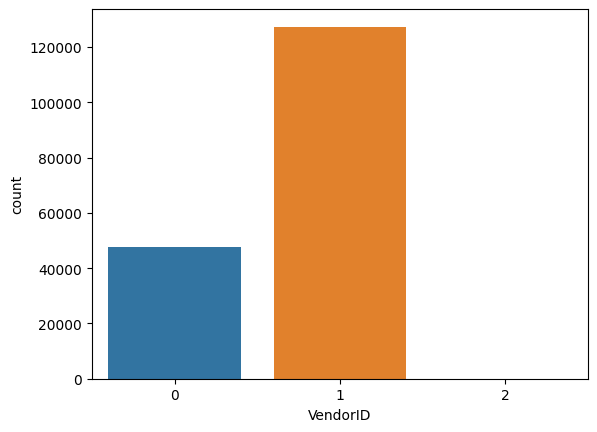

In [224]:
sns.countplot(x='VendorID',data=preprocessed_train_data)

In [225]:
data=preprocessed_train_data.copy()

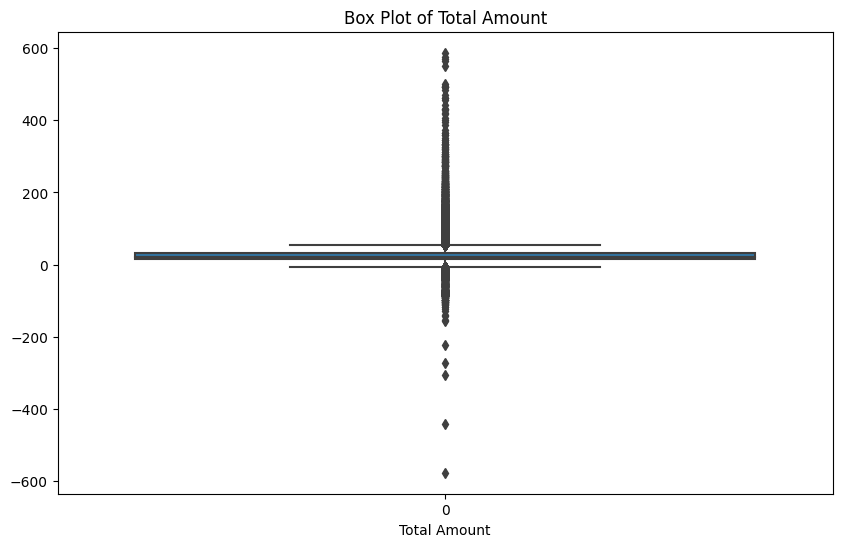

In [226]:
plt.figure(figsize=(10, 6))
sns.boxplot(data['total_amount'])
plt.title('Box Plot of Total Amount')
plt.xlabel('Total Amount')
plt.show()


**Insight:**

The median of total trip costs is visible, providing an idea of the typical trip charge.

Outliers are present, suggesting some trips have unusually high or low total amounts.


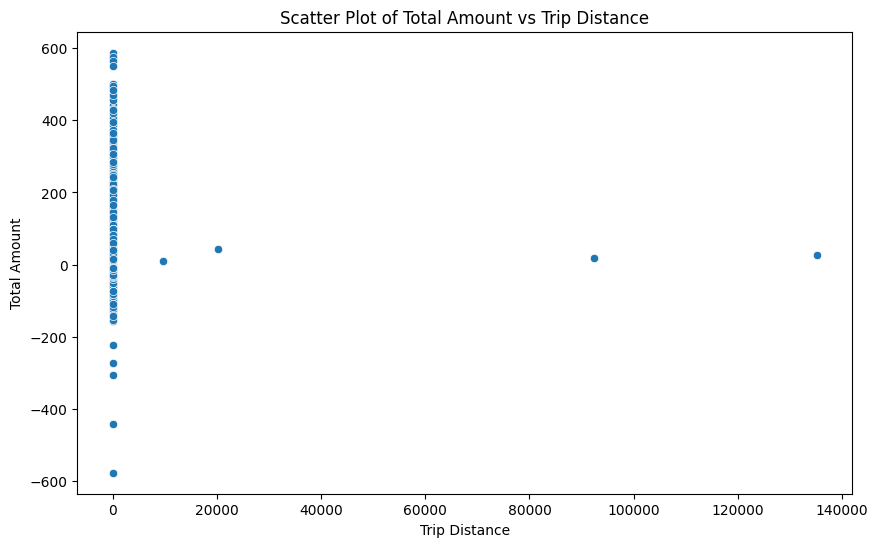

In [227]:
# Scatter Plot of Total Amount vs Trip Distance
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='total_amount', data=data)
plt.title('Scatter Plot of Total Amount vs Trip Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Total Amount')
plt.show()

**Insight:**

The presence of a strong linear correlation or a distinct trend can be indicative of a direct relationship between distance and amount

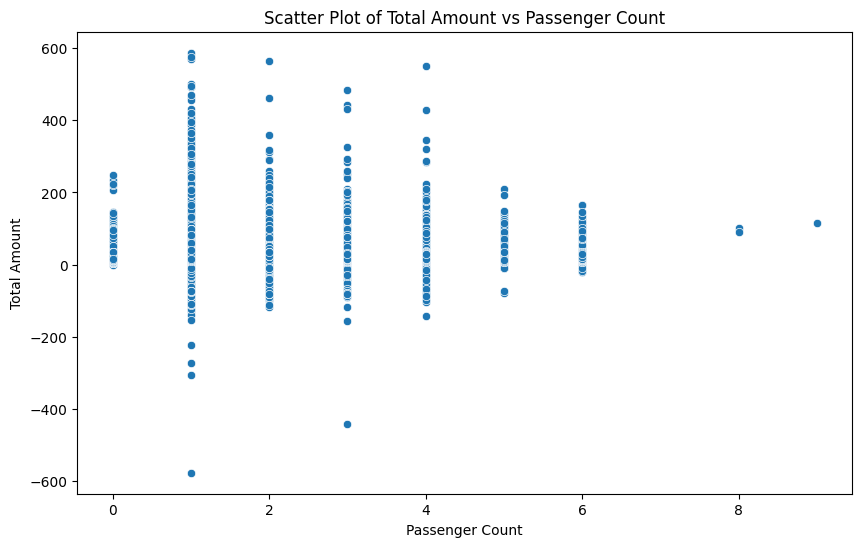

In [228]:
# Scatter Plot for passenger_count and total_amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='passenger_count', y='total_amount', data=train_data)
plt.title('Scatter Plot of Total Amount vs Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Total Amount')
plt.show()


**Insight:**

There is no clear trend indicating that the number of passengers significantly affects the total trip cost.

Negative amounts could indicate refunds given to passengers or cancellations of services where the company returned money to the customer.

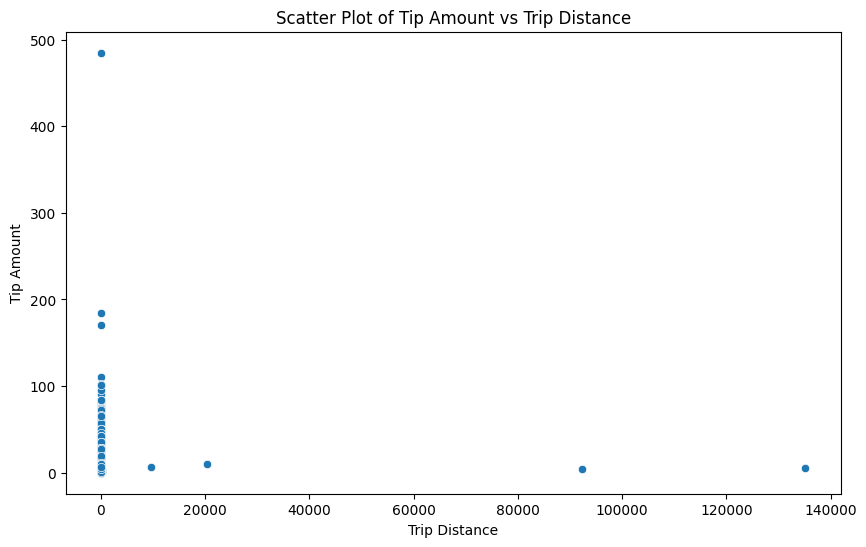

In [229]:
# Scatter Plot for trip_distance and tip_amount
plt.figure(figsize=(10, 6))
sns.scatterplot(x='trip_distance', y='tip_amount', data=train_data)
plt.title('Scatter Plot of Tip Amount vs Trip Distance')
plt.xlabel('Trip Distance')
plt.ylabel('Tip Amount')
plt.show()

**Insight:**

This also does not show a consistent trend, indicating that the length of the trip does not uniformly influence the amount of tips given.



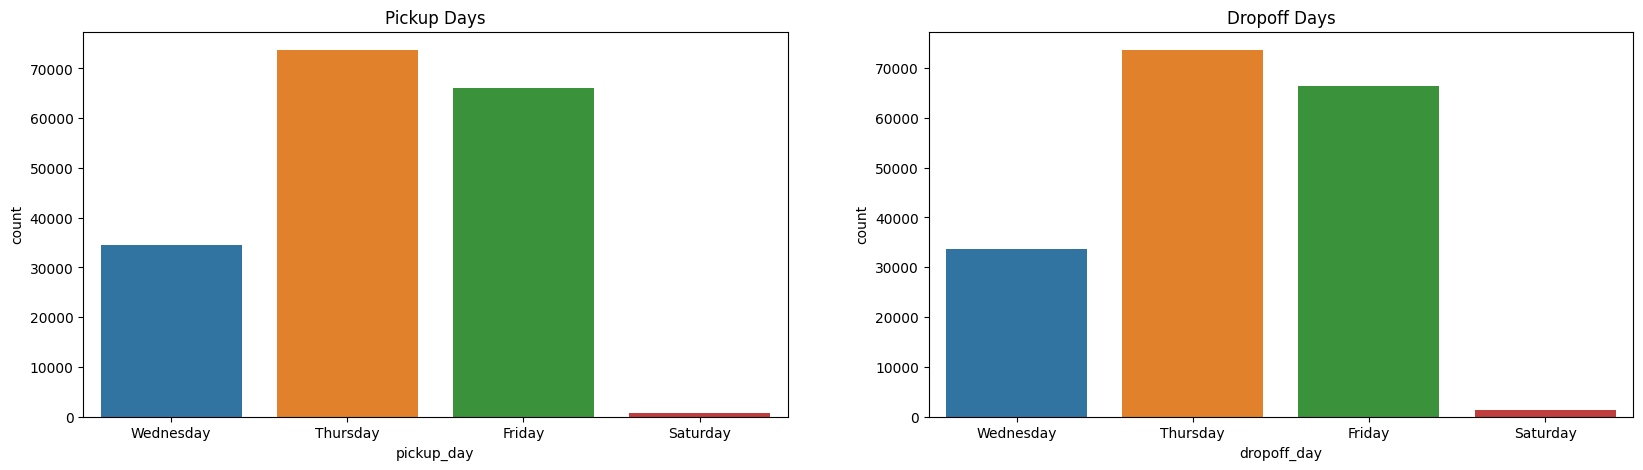

In [230]:
figure,(ax1,ax2)=plt.subplots(ncols=2,figsize=(20,5))
ax1.set_title('Pickup Days')
ax=sns.countplot(x="pickup_day",data=data,ax=ax1)
ax2.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_day",data=data,ax=ax2)


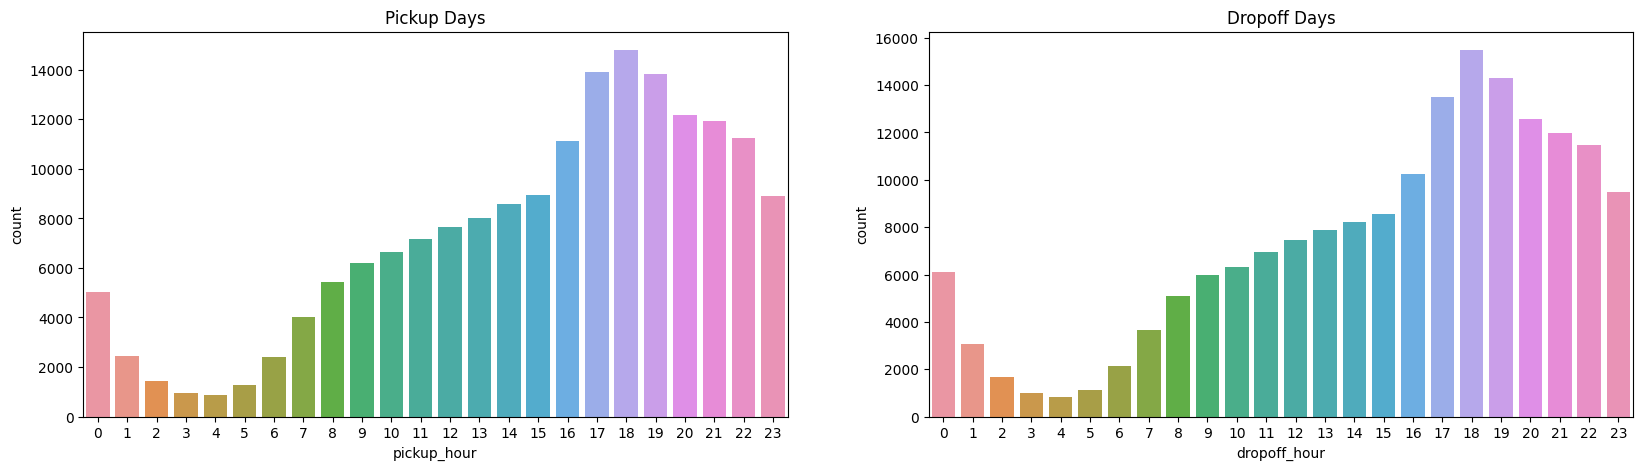

In [231]:
figure,(ax9,ax10)=plt.subplots(ncols=2,figsize=(20,5))
ax9.set_title('Pickup Days')
ax=sns.countplot(x="pickup_hour",data=data,ax=ax9)
ax10.set_title('Dropoff Days')
ax=sns.countplot(x="dropoff_hour",data=data,ax=ax10)

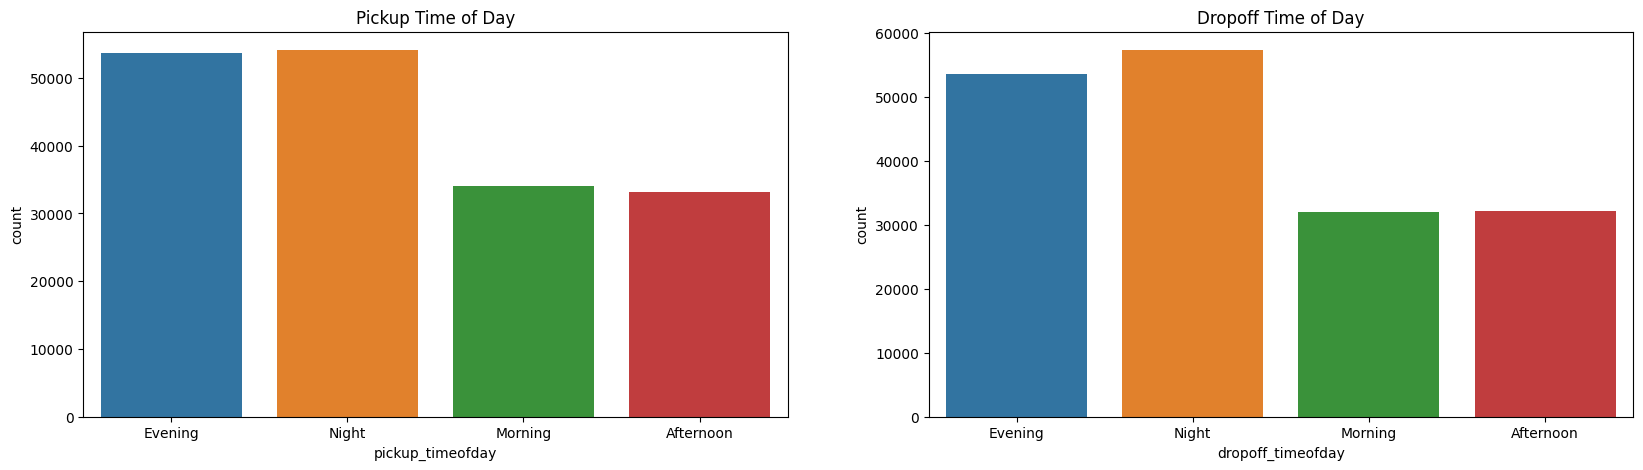

In [232]:
figure,(ax3,ax4)=plt.subplots(ncols=2,figsize=(20,5))
ax3.set_title('Pickup Time of Day')
ax=sns.countplot(x="pickup_timeofday",data=data,ax=ax3)
ax4.set_title('Dropoff Time of Day')
ax=sns.countplot(x="dropoff_timeofday",data=data,ax=ax4)

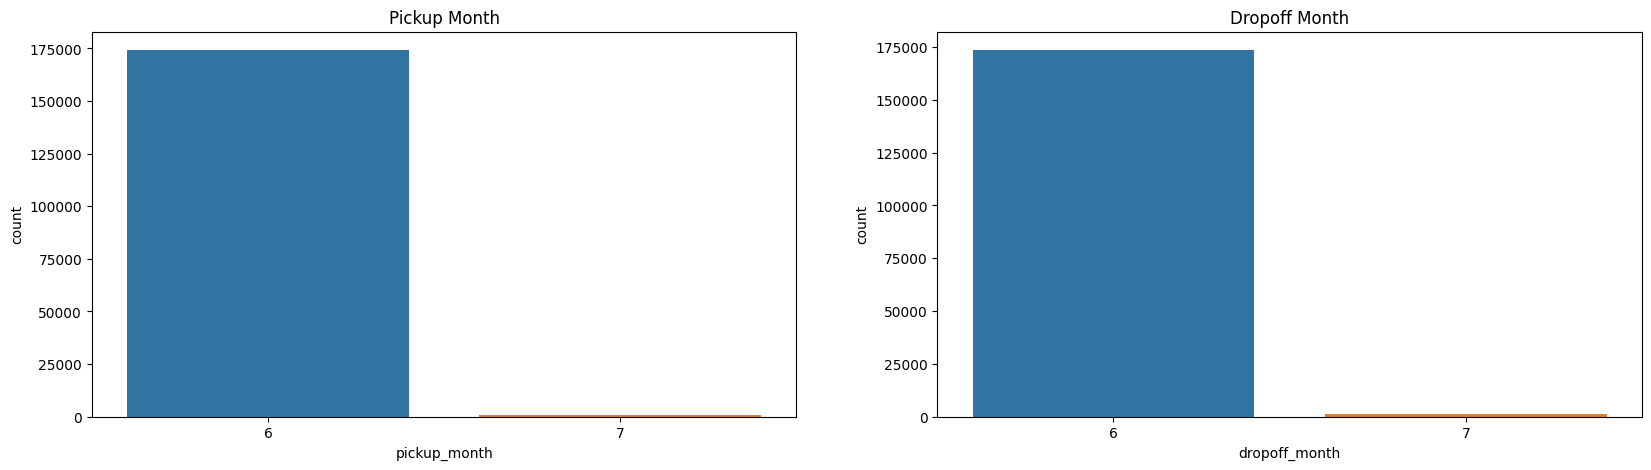

In [233]:
figure,(ax11,ax12)=plt.subplots(ncols=2,figsize=(20,5))
ax11.set_title('Pickup Month')
ax=sns.countplot(x="pickup_month",data=data,ax=ax11)
ax12.set_title('Dropoff Month')
ax=sns.countplot(x="dropoff_month",data=data,ax=ax12)

([<matplotlib.patches.Wedge at 0x7a0732127dc0>,
 [Text(-0.831708793660983, 0.7199031063601495, 'Credit Card'),
  Text(0.6959035368620805, -0.851890995012183, 'Cash'),
  Text(1.069597656017548, -0.256828452944309, 'Wallet'),
  Text(1.0960585138544399, -0.09303619837029439, 'unknown'),
  Text(1.099748158053796, -0.023536967886350152, 'UPI')],
 [Text(-0.4536593419968998, 0.3926744216509906, '77.29%'),
  Text(0.3795837473793166, -0.4646678154611906, '17.22%'),
  Text(0.5834169032822989, -0.14008824706053216, '3.47%'),
  Text(0.5978500984660581, -0.05074701729288785, '1.33%'),
  Text(0.5998626316657069, -0.012838346119827353, '0.68%')])

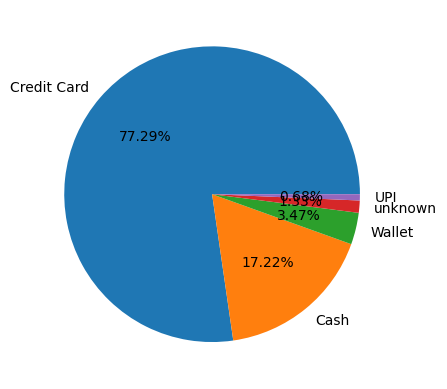

In [234]:
p_values=data['payment_type'].value_counts().values
p_names=data['payment_type'].value_counts().index
plt.pie(p_values,labels=p_names,autopct='%1.2f%%')

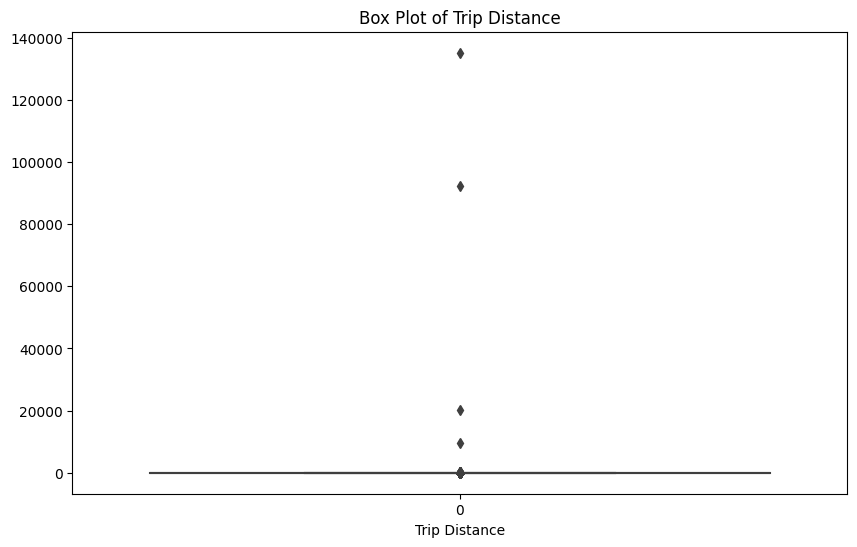

In [235]:
# Box Plot for trip_distance
plt.figure(figsize=(10, 6))
sns.boxplot(data['trip_distance'])
plt.title('Box Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()


**Insight :**

The whiskers extend to show the range of the data, and points beyond the whiskers are potential outliers.


The presence of outliers (points beyond the whiskers) suggests that there are trips with unusually long distances.

/tmp/ipykernel_32/2106070228.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['trip_distance'], shade=True)


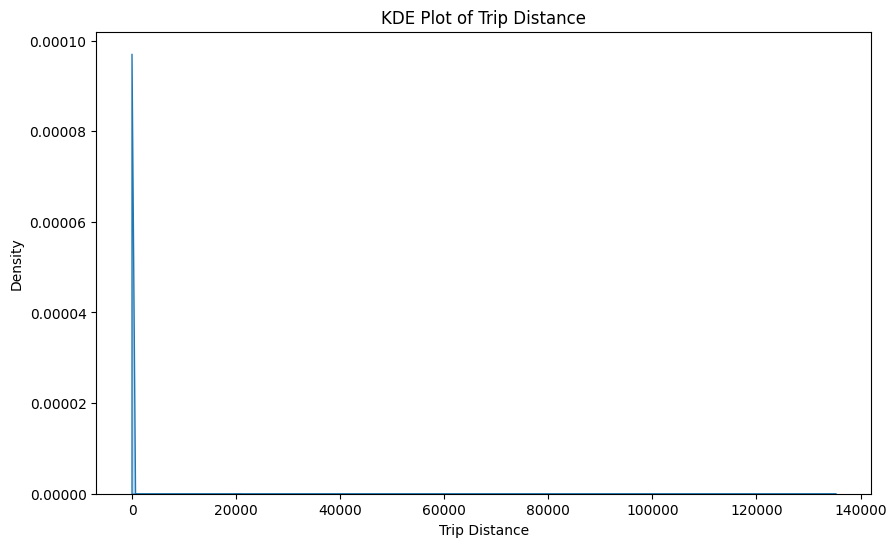

In [236]:
# KDE Plot for trip_distance
plt.figure(figsize=(10, 6))
sns.kdeplot(data['trip_distance'], shade=True)
plt.title('KDE Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()


**Insights :**

This particular KDE plot has a spike near zero, and the density quickly drops off, indicating that most trips are short, with very few long trips. 

The extreme values on the x-axis are so rare that the density near them is close to zero, which further suggests they may be outliers or errors.

In [237]:
data[data['trip_distance']>100]

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,...,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,total_pickup_hours,total_dropoff_hours,trip_duration_hours,pickup_timeofday,dropoff_timeofday
55147,1,1.0,9673.69,1.0,N,107,228,Credit Card,0.00,6.042202,...,3,15,15,6,6,87,87,0,Afternoon,Afternoon
59599,0,1.0,132.10,1.0,N,92,234,Cash,2.75,3.682359,...,4,23,2,6,6,95,98,3,Night,Night
70458,1,NaN,20314.00,NaN,NaN,249,84,Wallet,0.00,9.657420,...,5,23,0,6,7,119,120,1,Night,Night
85525,1,NaN,135182.06,NaN,NaN,133,80,Wallet,0.00,5.948871,...,3,5,4,6,6,77,76,1,Morning,Morning
107988,1,NaN,92292.43,NaN,NaN,55,71,Wallet,0.00,4.262185,...,3,3,4,6,6,75,76,1,Night,Morning
153336,1,1.0,104.09,5.0,N,242,30,Cash,0.00,0.380620,...,3,11,13,6,6,83,85,2,Morning,Afternoon
165589,1,2.0,143.35,5.0,N,209,115,Credit Card,0.00,0.951270,...,3,6,8,6,6,78,80,2,Morning,Morning


In [238]:
data[data['tip_amount']>150]

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,...,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,total_pickup_hours,total_dropoff_hours,trip_duration_hours,pickup_timeofday,dropoff_timeofday
32125,0,1.0,3.6,1.0,N,56,18,Credit Card,1.0,484.876151,...,4,22,22,6,6,118,118,0,Night,Night
52843,0,1.0,0.0,5.0,N,8,239,Credit Card,0.0,170.761373,...,4,1,1,6,6,97,97,0,Night,Night
114545,1,1.0,2.8,1.0,N,253,262,Credit Card,1.0,184.313458,...,4,23,22,6,6,119,118,1,Night,Night


In [239]:
data['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    167729
Y      1194
Name: count, dtype: int64

# **Handling Outliers**

In [240]:
data = data[data['trip_distance'] < 100]
data=data[data['tip_amount'] < 150]
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
VendorID,174990.0,0.728379,0.445606,0.000000,0.000000,1.000000,1.00000,2.000000
passenger_count,168916.0,1.357687,0.891297,0.000000,1.000000,1.000000,1.00000,9.000000
trip_distance,174990.0,3.672722,4.852871,0.000000,1.080000,1.840000,3.61000,84.160000
RatecodeID,168916.0,1.518258,6.514796,1.000000,1.000000,1.000000,1.00000,99.000000
PULocationID,174990.0,132.709909,76.148140,1.000000,67.000000,133.000000,199.00000,264.000000
DOLocationID,174990.0,132.701234,76.191657,1.000000,67.000000,133.000000,199.00000,264.000000
extra,174990.0,1.932227,1.948511,-7.500000,0.000000,1.000000,2.50000,11.750000
tip_amount,174990.0,6.122871,4.428813,0.000079,3.473299,5.286183,7.50267,110.927729
tolls_amount,174990.0,0.646668,2.327824,-29.300000,0.000000,0.000000,0.00000,80.000000
improvement_surcharge,174990.0,0.979687,0.198780,-1.000000,1.000000,1.000000,1.00000,1.000000


/tmp/ipykernel_32/2106070228.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['trip_distance'], shade=True)


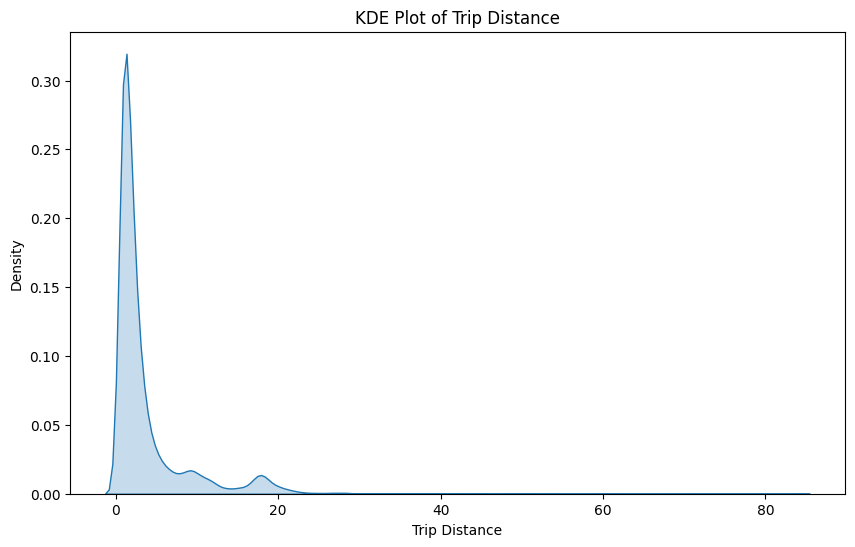

In [241]:
# KDE Plot for trip_distance
plt.figure(figsize=(10, 6))
sns.kdeplot(data['trip_distance'], shade=True)
plt.title('KDE Plot of Trip Distance')
plt.xlabel('Trip Distance')
plt.show()


In [242]:
numcols = data.select_dtypes(include='number').columns.to_list()

In [243]:
columns_to_remove = ['total_amount', 'VendorID', 'RatecodeID', 'PULocationID', 'DOLocationID',
                     'pickup_day_no', 'dropoff_day_no', 'pickup_hour', 'dropoff_hour',
                     'pickup_month', 'dropoff_month', 'total_pickup_hours',
                     'total_dropoff_hours', 'trip_duration_hours','store_and_fwd_flag', 'payment_type', 'pickup_day', 'dropoff_day',
       'pickup_timeofday', 'dropoff_timeofday']


numcols = [col for col in numcols if col not in columns_to_remove]


In [244]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 174990 entries, 0 to 174999
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               174990 non-null  int64  
 1   passenger_count        168916 non-null  float64
 2   trip_distance          174990 non-null  float64
 3   RatecodeID             168916 non-null  float64
 4   store_and_fwd_flag     168916 non-null  object 
 5   PULocationID           174990 non-null  int64  
 6   DOLocationID           174990 non-null  int64  
 7   payment_type           174990 non-null  object 
 8   extra                  174990 non-null  float64
 9   tip_amount             174990 non-null  float64
 10  tolls_amount           174990 non-null  float64
 11  improvement_surcharge  174990 non-null  float64
 12  total_amount           174990 non-null  float64
 13  congestion_surcharge   168916 non-null  float64
 14  Airport_fee            168916 non-null  f

In [245]:
data.columns

Index(['VendorID', 'passenger_count', 'trip_distance', 'RatecodeID',
       'store_and_fwd_flag', 'PULocationID', 'DOLocationID', 'payment_type',
       'extra', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'Airport_fee', 'pickup_day',
       'dropoff_day', 'pickup_day_no', 'dropoff_day_no', 'pickup_hour',
       'dropoff_hour', 'pickup_month', 'dropoff_month', 'total_pickup_hours',
       'total_dropoff_hours', 'trip_duration_hours', 'pickup_timeofday',
       'dropoff_timeofday'],
      dtype='object')

In [246]:
print(data[numcols].columns)

Index(['passenger_count', 'trip_distance', 'extra', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'congestion_surcharge',
       'Airport_fee'],
      dtype='object')


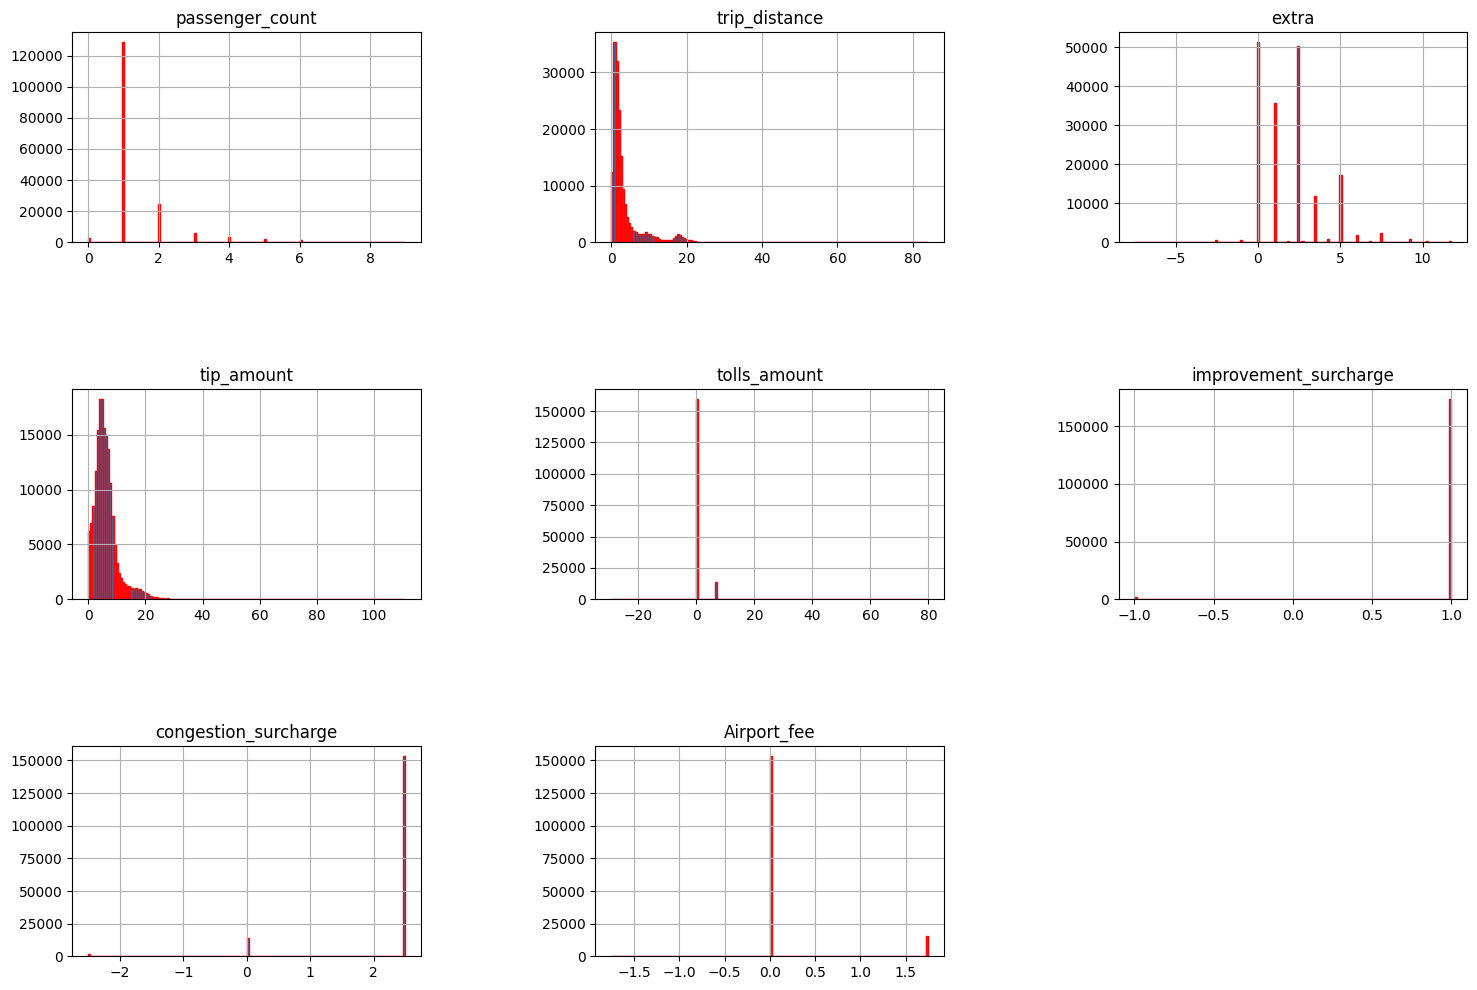

In [247]:
data[numcols].hist(bins = 150, edgecolor = 'red', figsize=(18,12))
plt.subplots_adjust(hspace = 0.7,wspace = 0.5)
plt.show()

**Insight:**

Normalized Distributions: The removal of outliers has resulted in more normalized distributions for variables like trip_distance and tip_amount.

Skewness:variables like tip_amount might still show a right skew, with most trips having lower tips and fewer trips with higher tips.

# **Features and Label**

In [248]:
X = data.drop('total_amount', axis=1)
y = data['total_amount']


# **Feature Engineering**

In [249]:
num_features = ['passenger_count', 'extra', 'tip_amount', 'tolls_amount', 
                'improvement_surcharge', 'congestion_surcharge', 'Airport_fee']
cat_features = ['VendorID', 'RatecodeID', 'store_and_fwd_flag', 'payment_type', 
                'pickup_day', 'dropoff_day', 'pickup_timeofday', 'dropoff_timeofday']
location_features = ['PULocationID', 'DOLocationID']

In [250]:
def frequency_encoding(dataframe, column):
    frequencies = dataframe[column].value_counts(normalize=True)
    return dataframe[column].map(frequencies)

X['PULocationID'] = frequency_encoding(X, 'PULocationID')
X['DOLocationID'] = frequency_encoding(X, 'DOLocationID')


In [251]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), num_features),
        ('trip_distance', StandardScaler(), ['trip_distance']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)
    ],
    remainder='passthrough' 
)

pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

pipeline.fit(X)

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

X_processed = pipeline.transform(X)

X_processed = pd.DataFrame(X_processed, columns=feature_names)

In [252]:
X_processed.shape

(174990, 53)

In [253]:
X_processed.columns

Index(['num__passenger_count', 'num__extra', 'num__tip_amount',
       'num__tolls_amount', 'num__improvement_surcharge',
       'num__congestion_surcharge', 'num__Airport_fee',
       'trip_distance__trip_distance', 'cat__VendorID_0', 'cat__VendorID_1',
       'cat__VendorID_2', 'cat__RatecodeID_1.0', 'cat__RatecodeID_2.0',
       'cat__RatecodeID_3.0', 'cat__RatecodeID_4.0', 'cat__RatecodeID_5.0',
       'cat__RatecodeID_99.0', 'cat__RatecodeID_nan',
       'cat__store_and_fwd_flag_N', 'cat__store_and_fwd_flag_Y',
       'cat__store_and_fwd_flag_nan', 'cat__payment_type_Cash',
       'cat__payment_type_Credit Card', 'cat__payment_type_UPI',
       'cat__payment_type_Wallet', 'cat__payment_type_unknown',
       'cat__pickup_day_Friday', 'cat__pickup_day_Saturday',
       'cat__pickup_day_Thursday', 'cat__pickup_day_Wednesday',
       'cat__dropoff_day_Friday', 'cat__dropoff_day_Saturday',
       'cat__dropoff_day_Thursday', 'cat__dropoff_day_Wednesday',
       'cat__pickup_timeofday_A

In [254]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (139992, 53)
X_test shape: (34998, 53)
y_train shape: (139992,)
y_test shape: (34998,)


# **Model Training**

In [255]:

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
# xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
# et_model = ExtraTreesRegressor(n_estimators=100, random_state=42)

# voting_model = VotingRegressor(estimators=[
#     ('rf', rf_model),
#     ('gb', gb_model),
#     ('xgb', xgb_model),
#     ('et', et_model)
# ])


# **Model Fitting**

In [256]:
rf_model.fit(X_train, y_train)
# gb_model.fit(X_train, y_train)
# xgb_model.fit(X_train, y_train)
# et_model.fit(X_train, y_train)
# voting_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

# **Model Prediction**

In [257]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    rmse = np.sqrt(mse)
    return {"MSE": mse, "MAE": mae, "R2": r2, "RMSE": rmse}

rf_metrics = evaluate_model(rf_model, X_test, y_test)
# gb_metrics = evaluate_model(gb_model, X_test, y_test)
# xgb_metrics = evaluate_model(xgb_model, X_test, y_test)
# et_metrics = evaluate_model(et_model, X_test, y_test)
# voting_metrics = evaluate_model(voting_model, X_test, y_test)

# **Model Evaluation**

In [258]:
print("Random Forest Metrics:", rf_metrics)
# print("Gradient Boosting Metrics:", gb_metrics)
# print("XGBoost Metrics:", xgb_metrics)
# print("Extra Trees Metrics:", et_metrics)
# print("Voting Regressor Metrics:", voting_metrics)

# Random Forest Metrics: {'MSE': 30.341296035884326, 'MAE': 2.682895685467741, 'R2': 0.9534508522848218, 'RMSE': 5.508293386874407}
# Gradient Boosting Metrics: {'MSE': 37.41792422554789, 'MAE': 2.9781504344274685, 'R2': 0.9425939986245018, 'RMSE': 6.1170192271684005}
# XGBoost Metrics: {'MSE': 30.839301470947422, 'MAE': 2.55787432399145, 'R2': 0.9526868200387274, 'RMSE': 5.553314458136458}
# Extra Trees Metrics: {'MSE': 35.06216491664799, 'MAE': 2.7814889729889343, 'R2': 0.9462081681682714, 'RMSE': 5.921331346635483}
# Voting Regressor Metrics: {'MSE': 28.775189286716152, 'MAE': 2.58013218089221, 'R2': 0.9558535490687214, 'RMSE': 5.36425104620544}


Random Forest Metrics: {'MSE': 29.95537918640436, 'MAE': 2.5842529973141324, 'R2': 0.9540429199542771, 'RMSE': 5.473150754949507}


# **HPT AND RESULTS**

In [259]:
# from sklearn.model_selection import GridSearchCV

# # Parameters for RandomForest
# param_grid_rf = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, n_jobs=-1)
# grid_search_rf.fit(X_train, y_train)


In [260]:
# param_grid_et = {
#     'n_estimators': [100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2]
# }

# grid_search_et = GridSearchCV(ExtraTreesRegressor(random_state=42), param_grid_et, cv=3, n_jobs=-1)
# grid_search_et.fit(X_train, y_train)


In [261]:
# rf_best_metrics = evaluate_model(grid_search_rf.best_estimator_, X_test, y_test)
# et_best_metrics = evaluate_model(grid_search_et.best_estimator_, X_test, y_test)

# print("Best RandomForest Metrics:", rf_best_metrics)
# print("Best ExtraTrees Metrics:", et_best_metrics)

# Best RandomForest Metrics: {'MSE': 32.341296035884326, 'MAE': 2.798895685467741, 'R2': 0.934508522848218, 'RMSE': 5.548293386874407}
# Extra Trees Metrics: {'MSE': 36.06216491664799, 'MAE': 2.7714889729889343, 'R2': 0.9345081681682714, 'RMSE': 6.021331346635483}

# **Comparing the Metrics**

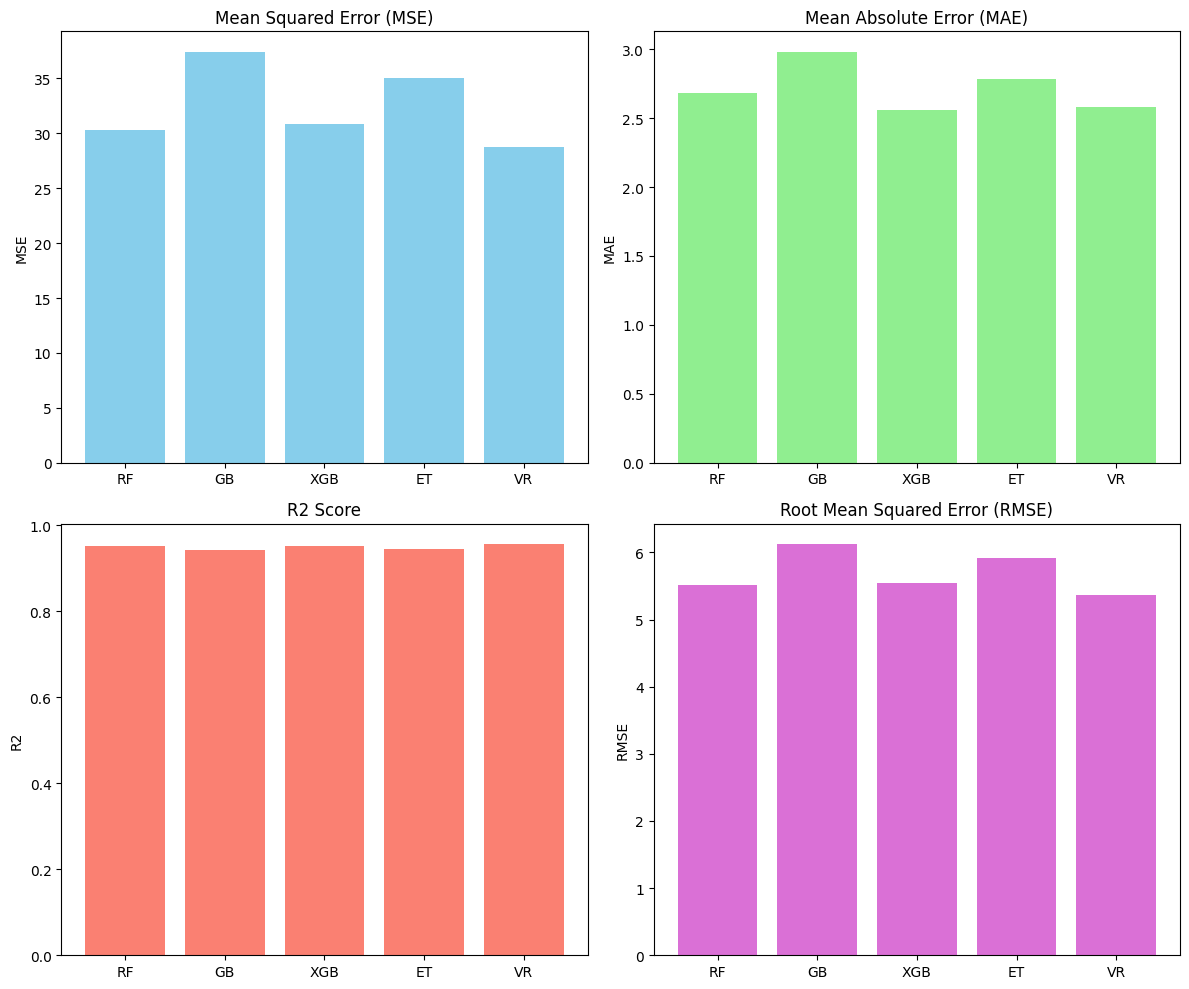

In [262]:

models = ['RF', 'GB', 'XGB', 'ET', 'VR']
mse = [30.34, 37.42, 30.84, 35.06, 28.78]
mae = [2.68, 2.98, 2.56, 2.78, 2.58]
r2 = [0.953, 0.943, 0.953, 0.946, 0.956]
rmse = [5.51, 6.12, 5.55, 5.92, 5.36]

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# MSE Bar Chart
axs[0, 0].bar(models, mse, color='skyblue')
axs[0, 0].set_title('Mean Squared Error (MSE)')
axs[0, 0].set_ylabel('MSE')

# MAE Bar Chart
axs[0, 1].bar(models, mae, color='lightgreen')
axs[0, 1].set_title('Mean Absolute Error (MAE)')
axs[0, 1].set_ylabel('MAE')

# R2 Bar Chart
axs[1, 0].bar(models, r2, color='salmon')
axs[1, 0].set_title('R2 Score')
axs[1, 0].set_ylabel('R2')

# RMSE Bar Chart
axs[1, 1].bar(models, rmse, color='orchid')
axs[1, 1].set_title('Root Mean Squared Error (RMSE)')
axs[1, 1].set_ylabel('RMSE')

plt.tight_layout()
plt.show()


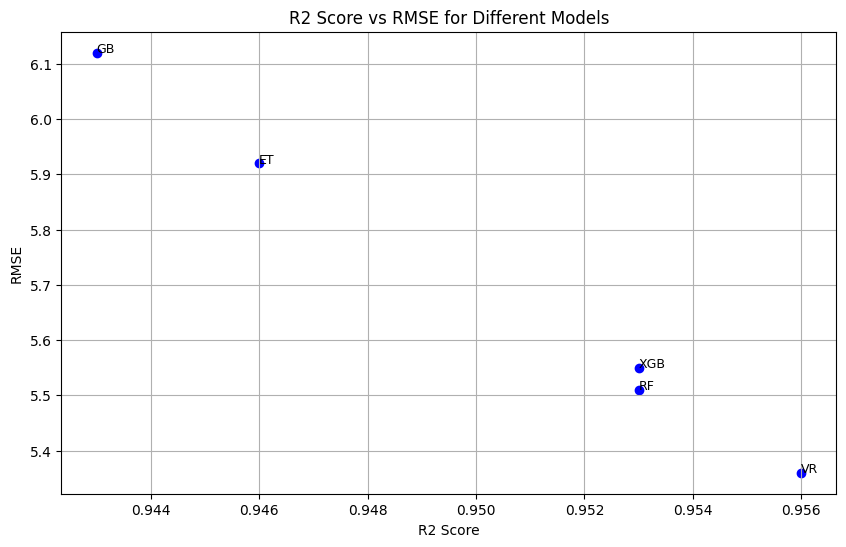

In [263]:
models = ['RF', 'GB', 'XGB', 'ET', 'VR']
r2 = [0.953, 0.943, 0.953, 0.946, 0.956]
rmse = [5.51, 6.12, 5.55, 5.92, 5.36]

plt.figure(figsize=(10, 6))
plt.scatter(r2, rmse, color='blue')

for i, model in enumerate(models):
    plt.text(r2[i], rmse[i], model, fontsize=9)

plt.title('R2 Score vs RMSE for Different Models')
plt.xlabel('R2 Score')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

**Insight :**

Based on the above scatter plot the best three models are votting regressor, random forest and xgboost regressor

# **Test Set**

In [264]:
test_data=preprocessed_test_data

In [265]:
test_data.shape

(50000, 27)

In [266]:
test_data.head()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,extra,tip_amount,...,dropoff_day_no,pickup_hour,dropoff_hour,pickup_month,dropoff_month,total_pickup_hours,total_dropoff_hours,trip_duration_hours,pickup_timeofday,dropoff_timeofday
0,1,1.0,4.95,1.0,N,20,3,Credit Card,1.0,6.067612,...,3,0,0,6,6,72,72,0,Night,Night
1,1,1.0,2.10,1.0,N,9,81,Credit Card,2.5,6.191269,...,4,17,17,6,6,113,113,0,Evening,Evening
2,1,1.0,0.95,1.0,N,92,90,Cash,2.5,3.983872,...,3,18,19,6,6,90,91,1,Evening,Evening
3,0,1.0,0.80,1.0,N,19,102,Credit Card,3.5,6.839341,...,4,21,21,6,6,117,117,0,Night,Night
4,1,1.0,4.01,1.0,N,131,229,Cash,0.0,1.468943,...,3,14,15,6,6,86,87,1,Afternoon,Afternoon


In [267]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   VendorID               50000 non-null  int64  
 1   passenger_count        48221 non-null  float64
 2   trip_distance          50000 non-null  float64
 3   RatecodeID             48221 non-null  float64
 4   store_and_fwd_flag     48221 non-null  object 
 5   PULocationID           50000 non-null  int64  
 6   DOLocationID           50000 non-null  int64  
 7   payment_type           50000 non-null  object 
 8   extra                  50000 non-null  float64
 9   tip_amount             50000 non-null  float64
 10  tolls_amount           50000 non-null  float64
 11  improvement_surcharge  50000 non-null  float64
 12  congestion_surcharge   48221 non-null  float64
 13  Airport_fee            48221 non-null  float64
 14  pickup_day             50000 non-null  object 
 15  dr

In [268]:
test_data['PULocationID'] = frequency_encoding(test_data, 'PULocationID')
test_data['DOLocationID'] = frequency_encoding(test_data, 'DOLocationID')


In [269]:
Test =pipeline.transform(test_data)

In [270]:
Test.shape

(50000, 53)

In [271]:
y_pred=rf_model.predict(Test)

/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [272]:
submission=pd.DataFrame(columns=['ID','total_amount'])
submission['ID']=[i for i in range(1,len(y_pred)+1)]
submission['total_amount']=y_pred
submission.to_csv('submission.csv',index=False)

In [273]:
submission.head()

,ID,total_amount
0,1,36.6997
1,2,25.1827
2,3,15.4054
3,4,15.7117
4,5,26.8605
